混合精度的训练方式源自Nvidia与百度联手推出的论文"MIXED PRECISION TRAINING"，旨在利用float32与float16两种精度的数据类型保存与计算速度，以提升模型训练速度、减少显存占用，从而能够使用较大的batchsize进行训练。

日常深度学习系统一般使用单精度训练（float32），而半精度训练是利用float16来保存与计算，float16结构如下，其中1位符号位、5位指数位、10位小数位
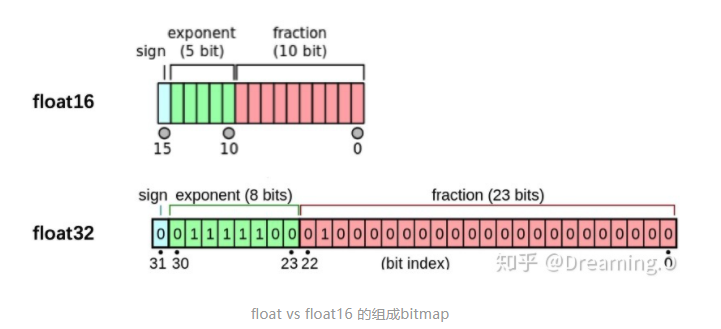

仅仅用float16来代替float32，确实能够减少计算开销，减少显存占用量，但会造成以下问题：<br/>
1)下溢出。float16能表示的精度范围位$2^{-24}$，如果梯度值小于这个数值，会被直接置0，梯度得不到更新；<br/>
2)量化误差（舍入误差）。float16能够表示的固定间隔较小，如果梯度更新值小于这个间隔，梯度同样无法更新，如下图所示：
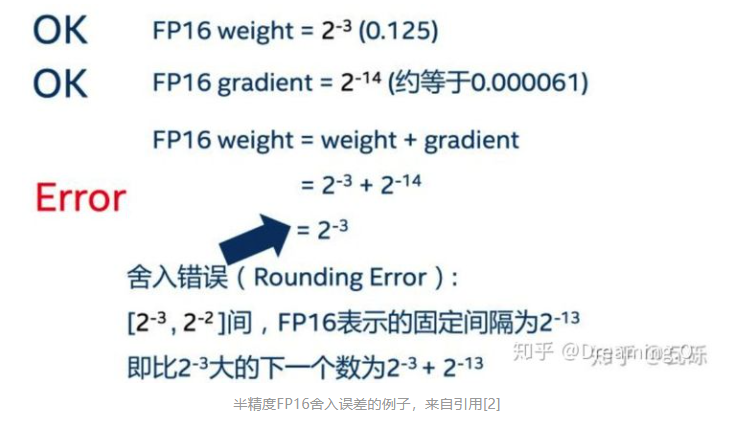

未解决以上两个问题，有以下几个思路：<br/>
1.FP32权重备份（混合精度）<br/>
即将weight、activations、gradient全部用float16来表示，但额外备份一份float32的weight，在前向传播与反向传播时用float16，在梯度更新时用float32，这样有效避免了量化误差：
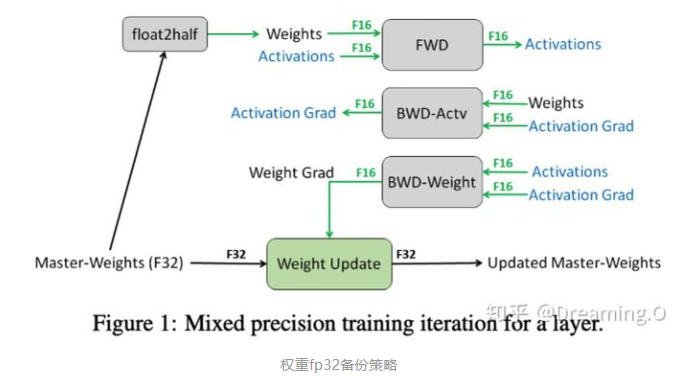
FP32备份不会太影响显存，因为在计算过程中，最占用显存的是activations

2.loss scale<br/>
主要为了解决下溢出（underflow）问题，训练后期锑度之普遍较小，乘上学习率会更小，因此可能出现下溢出的问题。如下图所示，SSD在训练过程中，有67%的梯度小于$2^{-24}$。
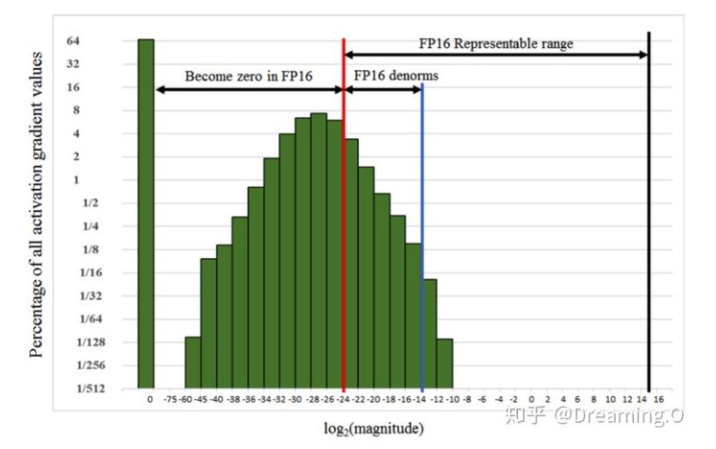
loss scale是对计算出来的loss值进行放大k倍，其值在8-32k之间（自动混合精度训练有一套自动缩放loss的策略，暂时略过），loss在根据链式法则反向传播的过程中会作用到中间的梯度上，因此会避免下溢出问题。<br/>
在进行更新的时候要将float16转化位float32，同时缩小k倍。<br/>

3.在forward与backwaed过程中，柚子额操作使用float32代替float16<br/>
如在矩阵乘法过程中，进行乘法与存储可以用float16,但矩阵加使用float16会损失精度，因此用float32来进行矩阵相加，加完之后再转为float16

硬件要求：<br/>
只有拥有tensorCore的GPU才支持混合精度训练（如tesla V100,TiTan V）

混合精度训练的一些坑：<br/>
1）判断你的GPU是否支持FP16：支持的有拥有Tensor Core的GPU（2080Ti、Titan、Tesla等），不支持的（Pascal系列）就不建议折腾了。<br/>
2)常数的范围：为了保证计算不溢出，首先要保证人为设定的常数（包括调用的源码中的）不溢出，如各种epsilon，INF（根据@哟林小平同学的反馈，改成-float('inf')就可以啦）等。<br/>
3)Dimension最好是8的倍数：Nvidia官方的文档的2.2条表示，维度都是8的倍数的时候，性能最好。<br/>
4)涉及到sum的操作要小心，很容易溢出，类似Softmax的操作建议用官方API，并定义成layer写在模型初始化里。<br/>
5)模型书写要规范：自定义的Layer写在模型初始化函数里，graph计算写在forward里。<br/>
6)某些不常用的函数，在使用前需要注册：amp.register_float_function(torch, 'sigmoid')<br/>
7)[某些函数（如einsum）暂不支持FP16加速，建议不要用的太heavy，xlnet的实现改FP16困扰了我很久。]大误，参考issue 802 slayton58的说法，注册好就可以强制加速了。<br/>
8)需要操作模型参数的模块（类似EMA），要使用AMP封装后的model。<br/>
9)需要操作梯度的模块必须在optimizer的step里，不然AMP不能判断grad是否为Nan。

混合精度的实现：<br/>
1.在pytorch1.5及之前的版本，要借用Nvidia的第三方库apex来实现：<br/>
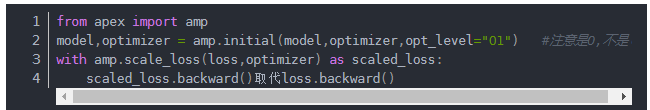
其中,opt_level配置如下：<br/>
O0:纯FP32训练，可作为accuracy的baseline；<br/>
O1:混合精度训练（推荐使用），根据黑白名单自动决定使用FP16(GEMM,卷积）还是FP32（softmax)进行计算。<br/>
O2:几乎FP16，混合精度训练，不存在黑白名单　，除了bacthnorm，几乎都是用FP16计算；<br/>
O3:纯FP16训练，很不稳定，但是可以作为speed的baseline;

In [2]:
#分布式训练：
import argparse
import apex import amp
import apex.parallel import convert_syncbn_model
import apex.parallel import DistributedDataParallel as DDP

定义超参数：
def parse():
    parser=argparse.ArgumentParser()
    parser.add_argument('--local_rank',type=int, default=0)  #local_rank指定了输出设备，默认为GPU可用列表中的第一个GPU，必须加上。
    ...
    args = parser.parser.parse_args()
    return args

主函数写：
def main():
    args = parse()
    torch.cuda.set_device(args.local_rank)  #必须写在下一句的前面
   torch.distributed.init_process_group(
       'nccl',
       init_method='env://')

导入数据接口，需要用DistributedSampler
    dataset = ...
    num_workers = 4 if cuda else 0
    train_sampler=torch.utils.data.distributed.DistributedSampler(dataset)
    loader = DataLoader(dataset, batch_size=batchsize, shuflle=False, num_worker=num_workers,pin_memory=cuda, drop_last=True, sampler=train_sampler)

定义模型：
net = XXXNet(using_amp=True)
net.train()
net= convert_syncbn_model(net)
device=torch.device('cuda:{}'.format(args.local_rank))
net=net.to(device)

定义优化器，损失函数，定义优化器一定要把模型搬运到GPU之上
apt = Adam([{'params':params_low_lr,'lr':4e-5},
    {'params':params_high_lr,'lr':1e-4}],weight_decay=settings.WEIGHT_DECAY)
crit = nn.BCELoss().to(device)

多GPU设置import torch.nn.parallel.DistributedDataParallel as DDP
net,opt = amp.initialize(net,opt,opt_level='o1')
net=DDP(net,delay_allreduce=True)loss使用方法：opt.zero_grad()with amp.scale_loss(loss, opt) as scaled_loss:    scaled_loss.backward()opt.step()加入主入口：if __name__ == '__main__':    main()无论是apex支持的DDP还是pytorch自身支持的DDP,都需使用torch.distributed.launch来使用，方法如下：CUDA_VISIBLE_DIVECES=1,2,4 python -m torch.distributed.launch --nproc_per_node=3 train.py1,2,4是GPU编号，nproc_per_node是指定用了哪些GPU,记得开头说的local_rank，是因为torch.distributed.launch会调用这个local_ran

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

分布式训练时保存模型注意点：<br/>
如果直接在代码中写torch.save来保存模型，则每个进程都会保存一次相同的模型，会存在写文件写到一半，会被个进程写覆盖的情况。如何避免呢?<br/>
可以用local_rank == 0来仅仅在第一个GPU上执行进程来保存模型文件。<br/>
if arg.local_rank == 0:<br/>
torch.save(xxx)

2.pytorch1.5之后的版本<br/>
有两个接口：autocast和Gradscaler<br/>

In [3]:

#1)autocast<br/>
from torch.cuda.amp import autocast as autocast

model=Net().cuda()
optimizer=optim.SGD(model.parameters(),...)

for input,target in data:
  optimizer.zero_grad()

  with autocast():
    output=model(input)
    loss = loss_fn(output,target)

  loss.backward()
  optimizer.step()

NameError: name 'Net' is not defined

可以使用autocast的context managers语义（如上），也可以使用decorators语义。当进入autocast上下文后，在这之后的cuda ops会把tensor的数据类型转换为半精度浮点型，从而在不损失训练精度的情况下加快运算。而不需要手动调用.half(),框架会自动完成转换。

不过，autocast上下文只能包含网络的前向过程(包括loss的计算），不能包含反向传播，因为BP的op会使用和前向op相同的类型。<br/>
当然，有时在autocast中的代码会报错：<br/>
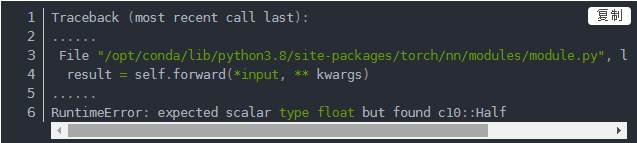
对于RuntimeError:expected scaler type float but found c10:Half,应该是个bug,可在tensor上手动调用.float()来让type匹配。

In [4]:
#2)GradScaler
rom torch.cuda.amp import autocast as autocast

model=Net().cuda()
optimizer=optim.SGD(model.parameters(),...)

scaler = GradScaler() #训练前实例化一个GradScaler对象

for epoch in epochs:
  for input,target in data:
    optimizer.zero_grad()

    with autocast():　＃前后开启autocast
      output=model(input)
      loss = loss_fn(output,targt)

    scaler.scale(loss).backward()  #为了梯度放大
    #scaler.step()　首先把梯度值unscale回来，如果梯度值不是inf或NaN,则调用optimizer.step()来更新权重，否则，忽略step调用，从而保证权重不更新。　　 scaler.step(optimizer)
    scaler.update()  #准备着，看是否要增大scaler

SyntaxError: invalid syntax (<ipython-input-4-53e20e3ca363>, line 2)

scaler的大小在每次迭代中动态估计，为了尽可能减少梯度underflow，scaler应该更大；但太大，半精度浮点型又容易overflow（变成inf或NaN).所以，动态估计原理就是在不出现if或NaN梯度的情况下，尽可能的增大scaler值。在每次scaler.step(optimizer)中，都会检查是否有inf或NaN的梯度出现：<br/>
如果出现inf或NaN,scaler.step(optimizer)会忽略此次权重更新(optimizer.step()），并将scaler的大小缩小（乘上backoff_factor)；<br/>
如果没有出现inf或NaN,那么权重正常更新，并且当连续多次(growth_interval指定)没有出现inf或NaN，则scaler.update()会将scaler的大小增加(乘上growth_factor)。

对于分布式训练，由于autocast是thread local的，要注意以下情形：

In [5]:
#(1)torch.nn.DataParallel：
#以下代码分布式是不生效的
model = MyModel()
dp_model = nn.DataParallel(model)

with autocast():
    output=dp_model(input)
loss=loss_fn(output)
#需使用autocast装饰model的forward函数
MyModel(nn.Module):
    @autocast()
    def forward(self, input):
        ...
        
#alternatively
MyModel(nn.Module):
    def forward(self, input):
        with autocast():
            ...


model = MyModel()
dp_model=nn.DataParallel(model)

with autocast():
    output=dp_model(input)
    loss = loss_fn(output)

SyntaxError: invalid syntax (<ipython-input-5-dd60acf23d44>, line 10)

(2)torch.nn.DistributedDataParallel:<br/>
同样，对于多GPU,也需要autocast装饰model的forward方法，保证autocast在进程内部生效。